# 0. Install and Import dependencies

In [168]:
# !pip install tensorflow-gpu==1.15.0 tensorflow==1.15.0 stable-baselines gym-anytrading gym

In [169]:
# Gym stuff
import gymnasium as gym
import gym_anytrading
from gym_anytrading.envs import StocksEnv
from finta import TA

# Stable baselines - rl stuff
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C, PPO, DQN

# Processing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import quantstats as qs

In [170]:
SEED = 5756

# Specify parameters
stock_name = 'XOM'

# Window size for training
train_window_size = 10
train_start = '2020-01-01'
train_end = '2022-12-31'

test_window_size = 10
learn_iteration = 50000

# Model parameters
model_name = 'A2C'

# Indicator parameters
sma_period = 10


# 1. Get Data

In [171]:
import yfinance as yf

df = yf.Ticker(stock_name)
df = df.history(period="max")
df = df.loc[train_start:, ['Open', 'High', 'Low', 'Close', 'Volume']]
print(df.shape)
df.head()

(1082, 5)


,Open,High,Low,Close,Volume
Date,,,,,
2020-01-02 00:00:00-05:00,56.468502,57.095572,56.468502,56.999104,12456400
2020-01-03 00:00:00-05:00,57.352838,57.376962,56.404199,56.540867,17386900
2020-01-06 00:00:00-05:00,56.532808,57.368903,56.460457,56.974976,20081900
2020-01-07 00:00:00-05:00,56.677520,56.693596,55.881624,56.508694,17387700
2020-01-08 00:00:00-05:00,56.363998,56.508707,55.608296,55.656536,15137700


In [172]:
TRAIN_ENV_FRAME_BOUND = (train_window_size, df[train_start:train_end].shape[0])
TEST_ENV_FRAME_BOUND = (df[train_start:train_end].shape[0] + test_window_size, df.shape[0])

# 2.1 Add Custom Indicators

## 2.1.3. Calculate SMA, RSI and OBV

In [173]:
df['SMA'] = TA.SMA(df, sma_period)
df['RSI'] = TA.RSI(df)
df['OBV'] = TA.OBV(df)
df.fillna(0, inplace=True)

## 2.1.4. Create New Environments

In [174]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Low', 'Volume','SMA', 'RSI', 'OBV']].to_numpy()[start:end]
    return prices, signal_features

In [175]:
class MyCustomEnv(StocksEnv):
    _process_data = add_signals

# 3. Build Environment and Train

In [176]:
env2 = MyCustomEnv(df=df, frame_bound=TRAIN_ENV_FRAME_BOUND, window_size=train_window_size)
env_maker = lambda: env2
env = DummyVecEnv([env_maker])

In [177]:
from sb3_contrib import RecurrentPPO

if model_name == 'A2C':
    model = A2C('MlpPolicy', env, verbose=0, seed=SEED) 
    model.learn(total_timesteps=learn_iteration)
elif model_name == 'RecurrentPPO':
    model = RecurrentPPO("MlpLstmPolicy", env, verbose=0, seed=SEED)
    model.learn(total_timesteps=learn_iteration)
elif model_name == 'PPO':
    model = PPO('MlpPolicy', env, verbose=0, seed=SEED) 
    model.learn(total_timesteps=learn_iteration)
elif model_name == 'DQN':
    model = DQN('MlpPolicy', env, verbose=0, seed=SEED) 
    model.learn(total_timesteps=learn_iteration)

# 4. Evaluation

In [178]:
env = MyCustomEnv(df=df, frame_bound=TEST_ENV_FRAME_BOUND, window_size=test_window_size)
observation, info = env.reset()
while True: 
    observation = observation[np.newaxis, ...]
    action, _states = model.predict(observation)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    if done:
        print("info", info)
        break

info {'total_reward': 8.423482891722884, 'total_profit': 1.083613598301175, 'position': <Positions.Long: 1>}


In [179]:
total_profit = round(info['total_profit'], 2)

# Report output
trade_strategy_output = f".\\reports\\{stock_name}_{model_name}_PROFIT{total_profit}_WINSIZE{train_window_size}_ITER{learn_iteration}_trade_strategy.png"
report_output = f".\\reports\\{stock_name}_{model_name}_PROFIT{total_profit}_WINSIZE{train_window_size}_ITER{learn_iteration}_reports.html"

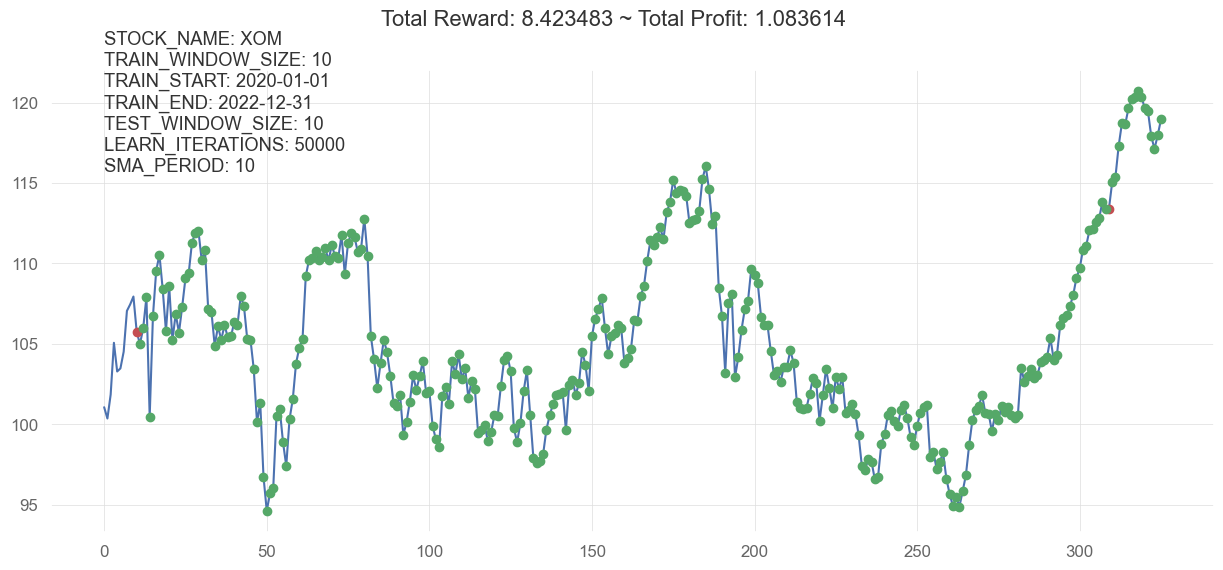

In [180]:
desc = f'STOCK_NAME: {stock_name}\nTRAIN_WINDOW_SIZE: {train_window_size}\nTRAIN_START: {train_start}\nTRAIN_END: {train_end}\nTEST_WINDOW_SIZE: {test_window_size}\nLEARN_ITERATIONS: {learn_iteration}\nSMA_PERIOD: {sma_period}'

plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.text(0, env.prices.max() - 5, desc)
plt.savefig(trade_strategy_output)
plt.show()

# 5. QuantStats

c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

                           Strategy
-------------------------  ----------
Start Period               2023-01-20
End Period                 2024-04-19
Risk-Free Rate             0.0%
Time in Market             1.0%

Cumulative Return          8.36%
CAGR﹪                     4.55%

Sharpe                     1.11
Prob. Sharpe Ratio         99.7%
Smart Sharpe               1.1
Sortino                    -
Smart Sortino              -
Sortino/√2                 -
Smart Sortino/√2           -
Omega                      -

Max Drawdown               %
Longest DD Days            -
Volatility (ann.)          5.97%
Calmar                     -
Skew                       16.1
Kurtosis                   269.43

Expected Daily %           0.03%
Expected Monthly %         0.5%
Expected Yearly %          4.1%
Kelly Criterion            -
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.59%
Expected Shortfall (cVaR)  -0.59%

Max Consecutive Wins       1
Max Consecutive Losses     0
Gain/

c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


None

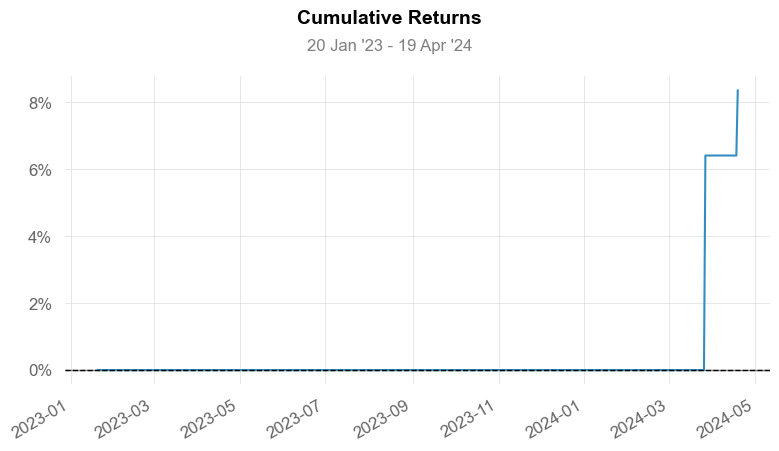

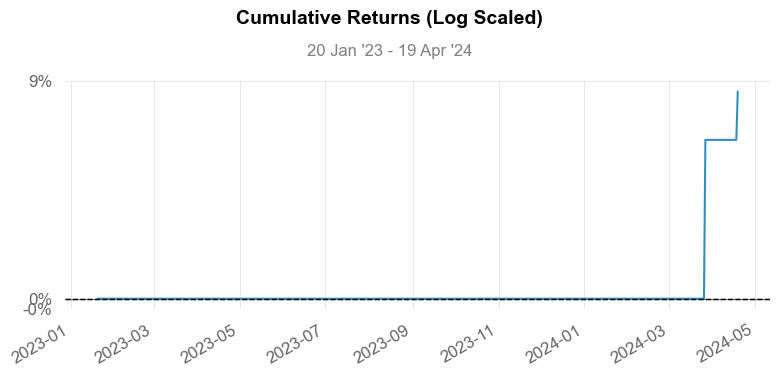

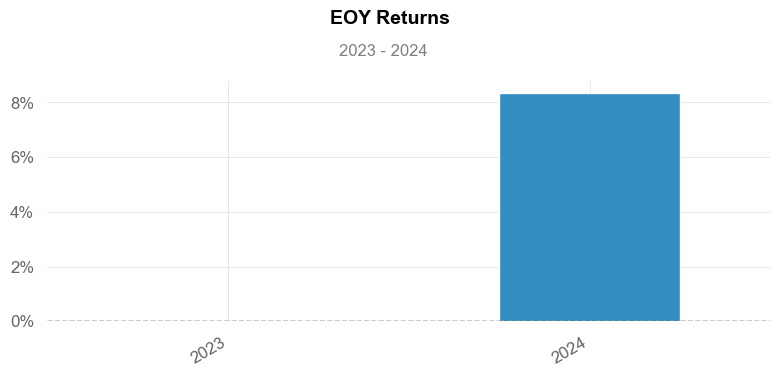

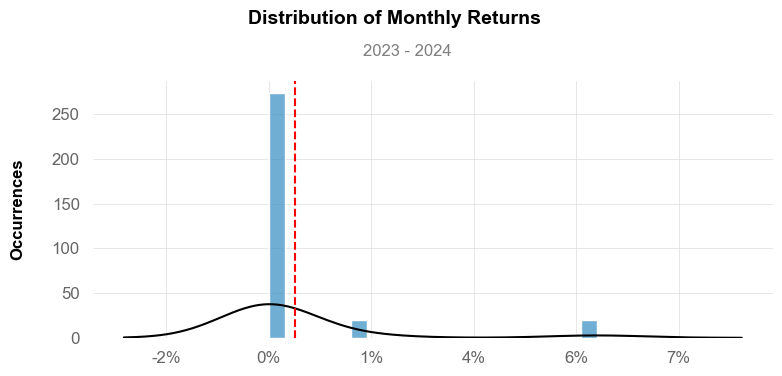

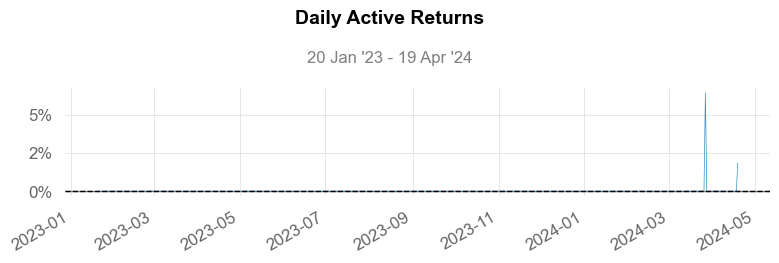

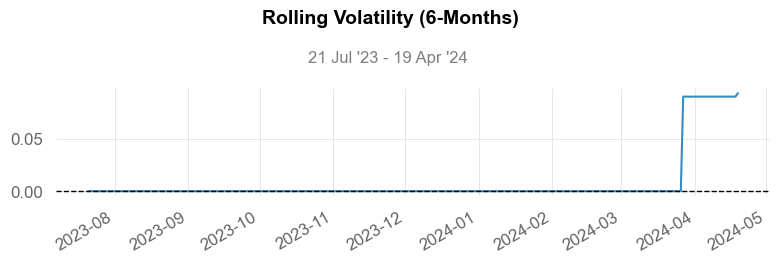

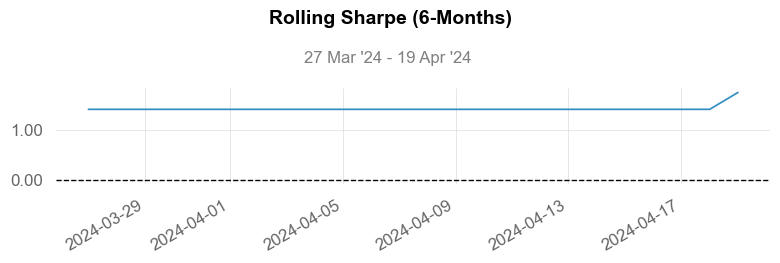

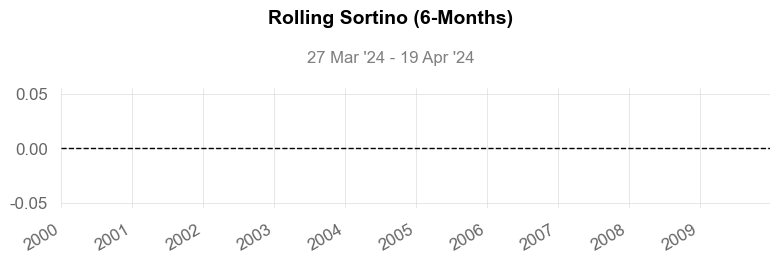

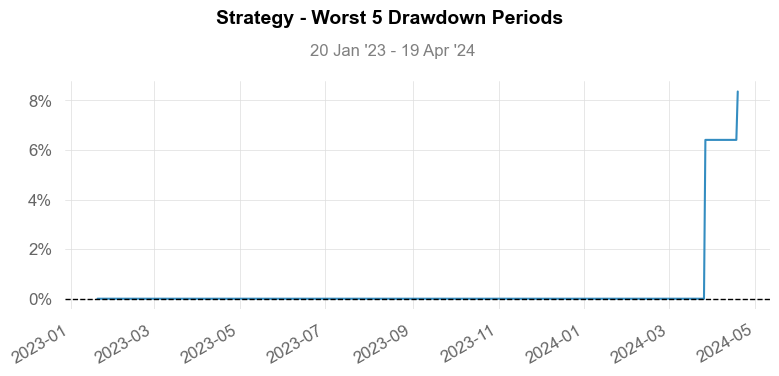

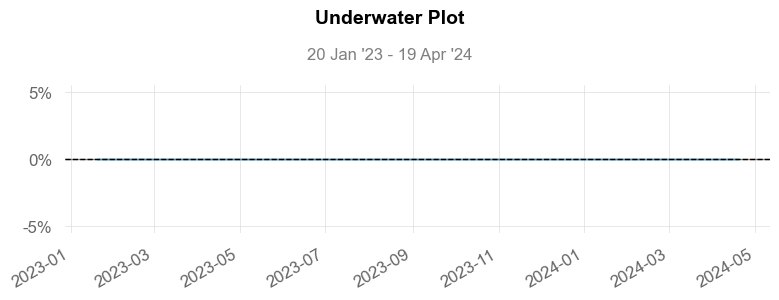

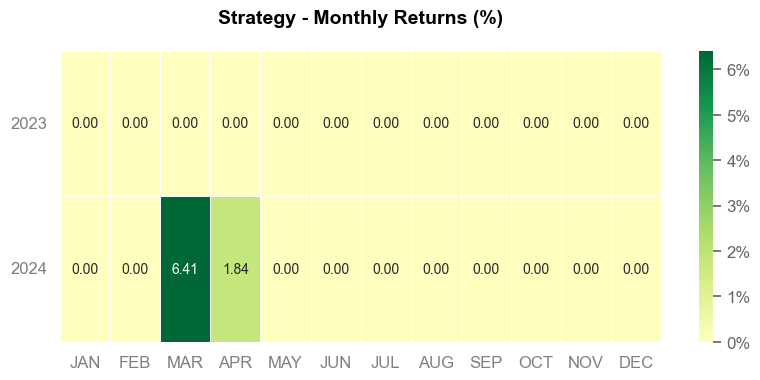

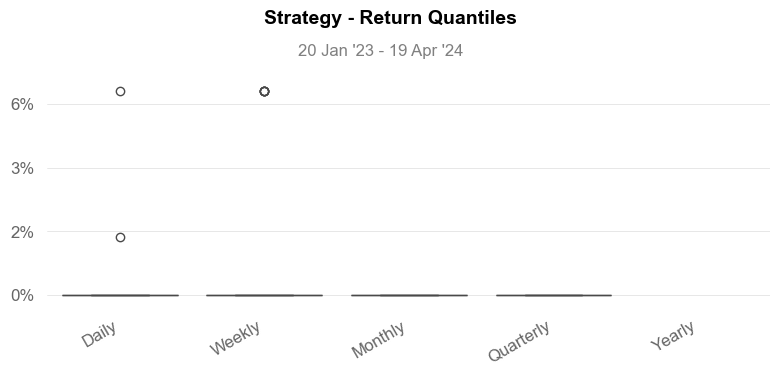

c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

In [181]:
qs.extend_pandas()

net_worth = pd.Series(env.unwrapped.history['total_profit'], index=df.index[TEST_ENV_FRAME_BOUND[0] + 1:TEST_ENV_FRAME_BOUND[1]])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)
qs.reports.html(returns, output=report_output)